### Import all relevant libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

sns.set(style="darkgrid")

### Load the tables

Table A is the dataset where the algorithm will be trained, whereas table B is the dataset for the validation of the method. The algorithm never sees Table B.

In [3]:
tA_orig = Table.read('../Datafiles/PhotoZFileA.vot')
tA_orig = tA_orig.to_pandas()
tA_orig = tA_orig.drop('Counter', axis=1)
tA_orig.to_csv('../Datafiles/PhotoZFileA.csv', index=False)

tB_orig = Table.read('../Datafiles/PhotoZFileB.vot')
tB_orig = tB_orig.to_pandas()
tB_orig = tB_orig.drop('Counter', axis=1)
tB_orig.to_csv('../Datafiles/PhotoZFileB.csv', index=False)

display(tA_orig)
display(tB_orig)

,mag_r,u-g,g-r,r-i,i-z,z_spec
0,18.914286,2.072901,1.386738,0.482288,0.272480,0.309728
1,19.394960,1.544794,1.557312,0.541681,0.418470,0.336479
2,19.886253,1.028398,1.764324,0.672249,0.374681,0.406500
3,17.561859,2.166397,1.304127,0.428728,0.303825,0.192485
4,18.495819,1.359457,1.720991,0.521324,0.360054,0.319904
...,...,...,...,...,...,...
74304,17.905106,1.300573,1.518801,0.522589,0.404392,0.261464
74305,17.588964,1.442886,1.408772,0.542276,0.394083,0.223003
74306,20.376284,1.748831,1.362972,0.759176,0.427336,0.478527
74307,18.126299,1.480217,1.483189,0.573711,0.359980,0.274434


,mag_r,u-g,g-r,r-i,i-z,z_spec
0,19.469849,1.528381,1.486521,0.539600,0.272343,0.293778
1,17.302969,2.128372,1.311499,0.482414,0.283367,0.201277
2,19.764093,2.184450,1.694365,0.621489,0.233627,0.393756
3,18.485493,1.707390,1.394760,0.463596,0.263309,0.248585
4,17.514053,1.668873,1.414905,0.486395,0.327213,0.246883
...,...,...,...,...,...,...
74552,19.249470,2.150196,1.741672,0.667749,0.391930,0.334896
74553,17.284691,2.181351,1.248009,0.470192,0.372684,0.188253
74554,18.674818,1.275618,1.606810,0.570326,0.312952,0.308946
74555,17.787334,2.003248,1.369568,0.521305,0.349138,0.228876


### Data exploration

Let's see what our tables contain. What columns do they have? Which columns are useful for us? Is there identical representation of the data among both tables, relatively speaking?

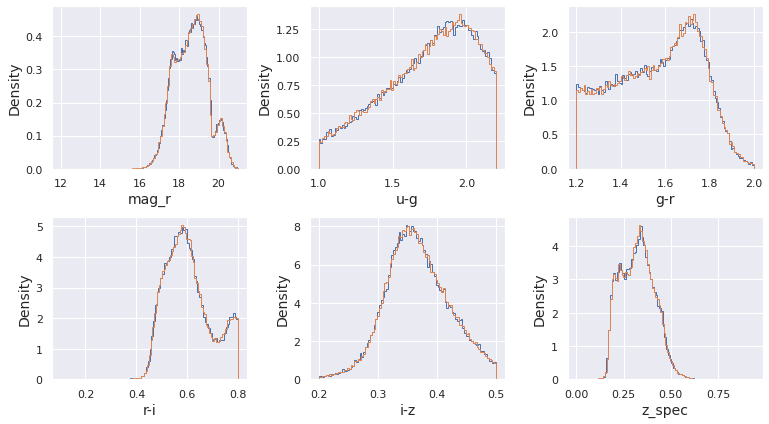

In [4]:
labels = tA_orig.columns

plt.figure(figsize=((3*3)*1.2, 3*2), layout='tight')
for i in range(len(labels)):
    key = labels[i]
    plt.subplot(2, 3, i+1)
    plt.hist(tA_orig[key], bins=100, histtype='step', density=True)
    plt.hist(tB_orig[key], bins=100, histtype='step', density=True)
    plt.xlabel(key, fontsize=14)
    plt.ylabel('Density', fontsize=14)
plt.show()

### Correlation heatmap

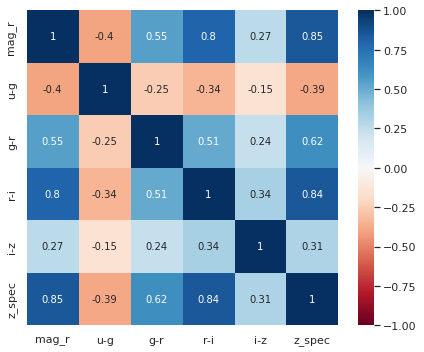

In [5]:
corr = tA_orig.corr()

plt.figure(figsize=(5*1.2, 5), layout='tight')
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)
plt.show()

### Correlation cornerplot

In [6]:
def corr_cornerplot(df, labels):
    plt.figure(figsize=(18, 18), layout='tight')
    cmap = plt.cm.cividis
    cmap.set_under(color='w')
    
    corr = df.corr()
    n = len(labels)
    for i in range(0, n):
        for j in range(0, n):
            if i >= j:
                plt.subplot(n, n, i*n+j+1)
                if i == j:
                    plt.hist(df[labels[i]], bins=100, density=True, histtype='step')
                    plt.xlabel(labels[i], fontsize=14)
                    if j == 0:
                        plt.ylabel('Density', fontsize=14)
                else:
                    plt.title('Corr: ' + repr(round(corr.loc[labels[j]][labels[i]], 3)), fontsize=12)
                    plt.hist2d(df[labels[j]], df[labels[i]], bins=80, cmap=cmap, vmin=1)
                    if j == 0:
                        plt.ylabel(labels[i], fontsize=14)
                    plt.xlabel(labels[j], fontsize=14)
    plt.show()

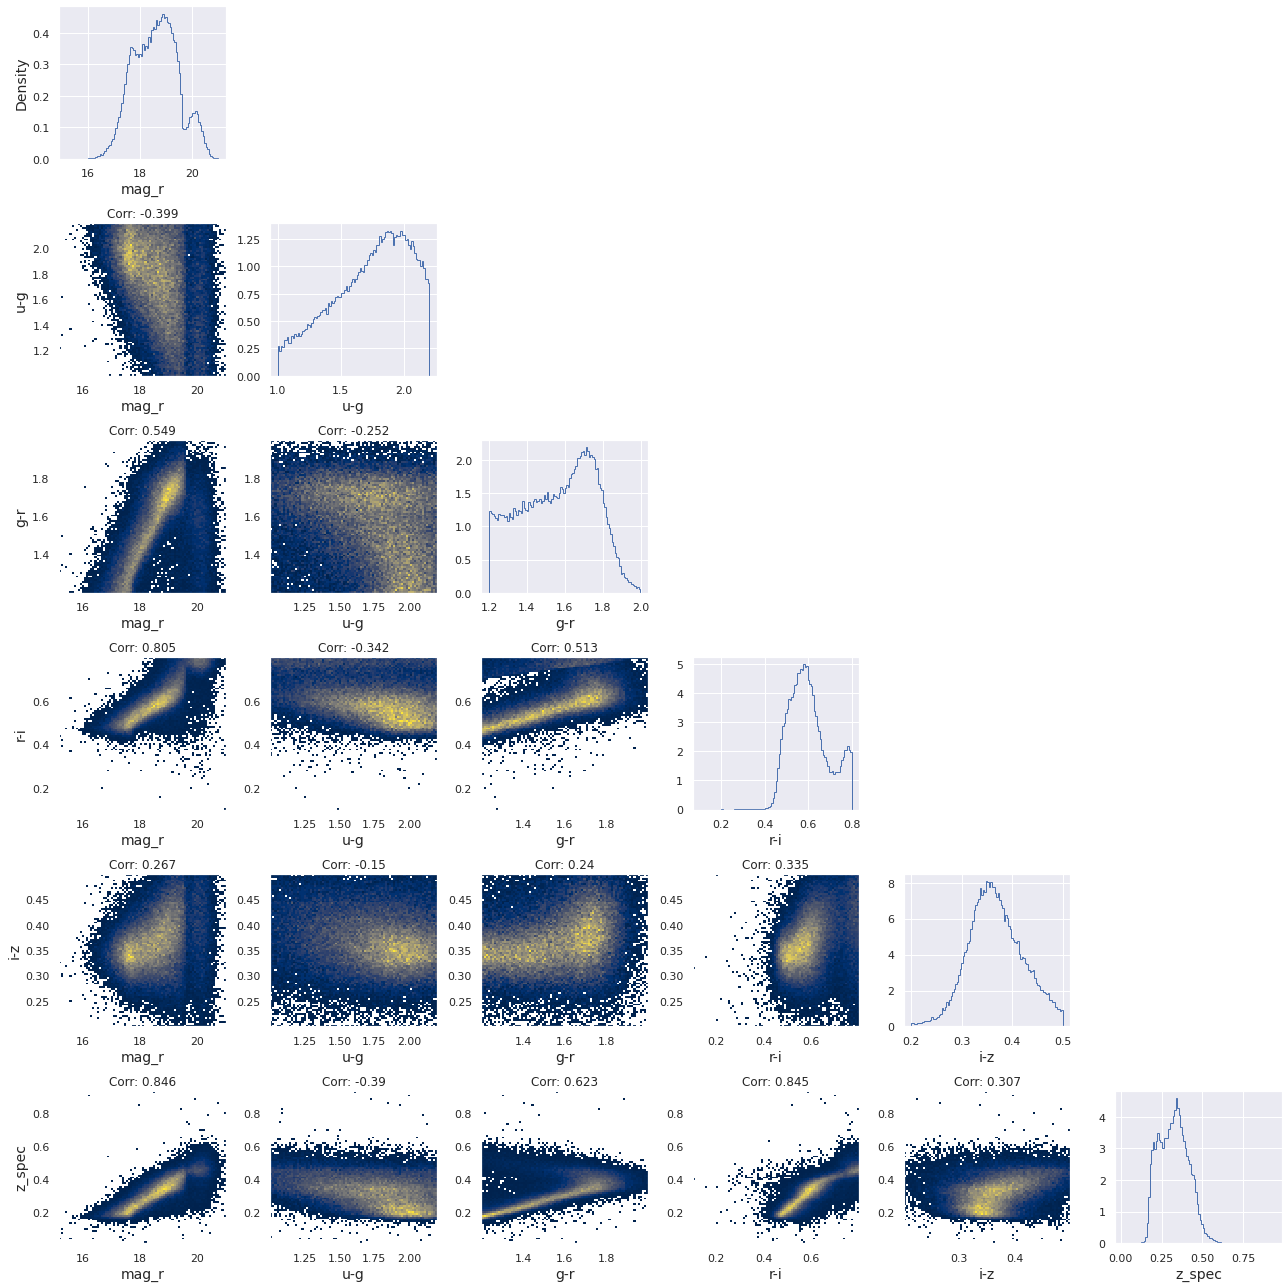

In [7]:
corr_cornerplot(tA_orig, tA_orig.columns)

### Make cuts to eliminate outliers

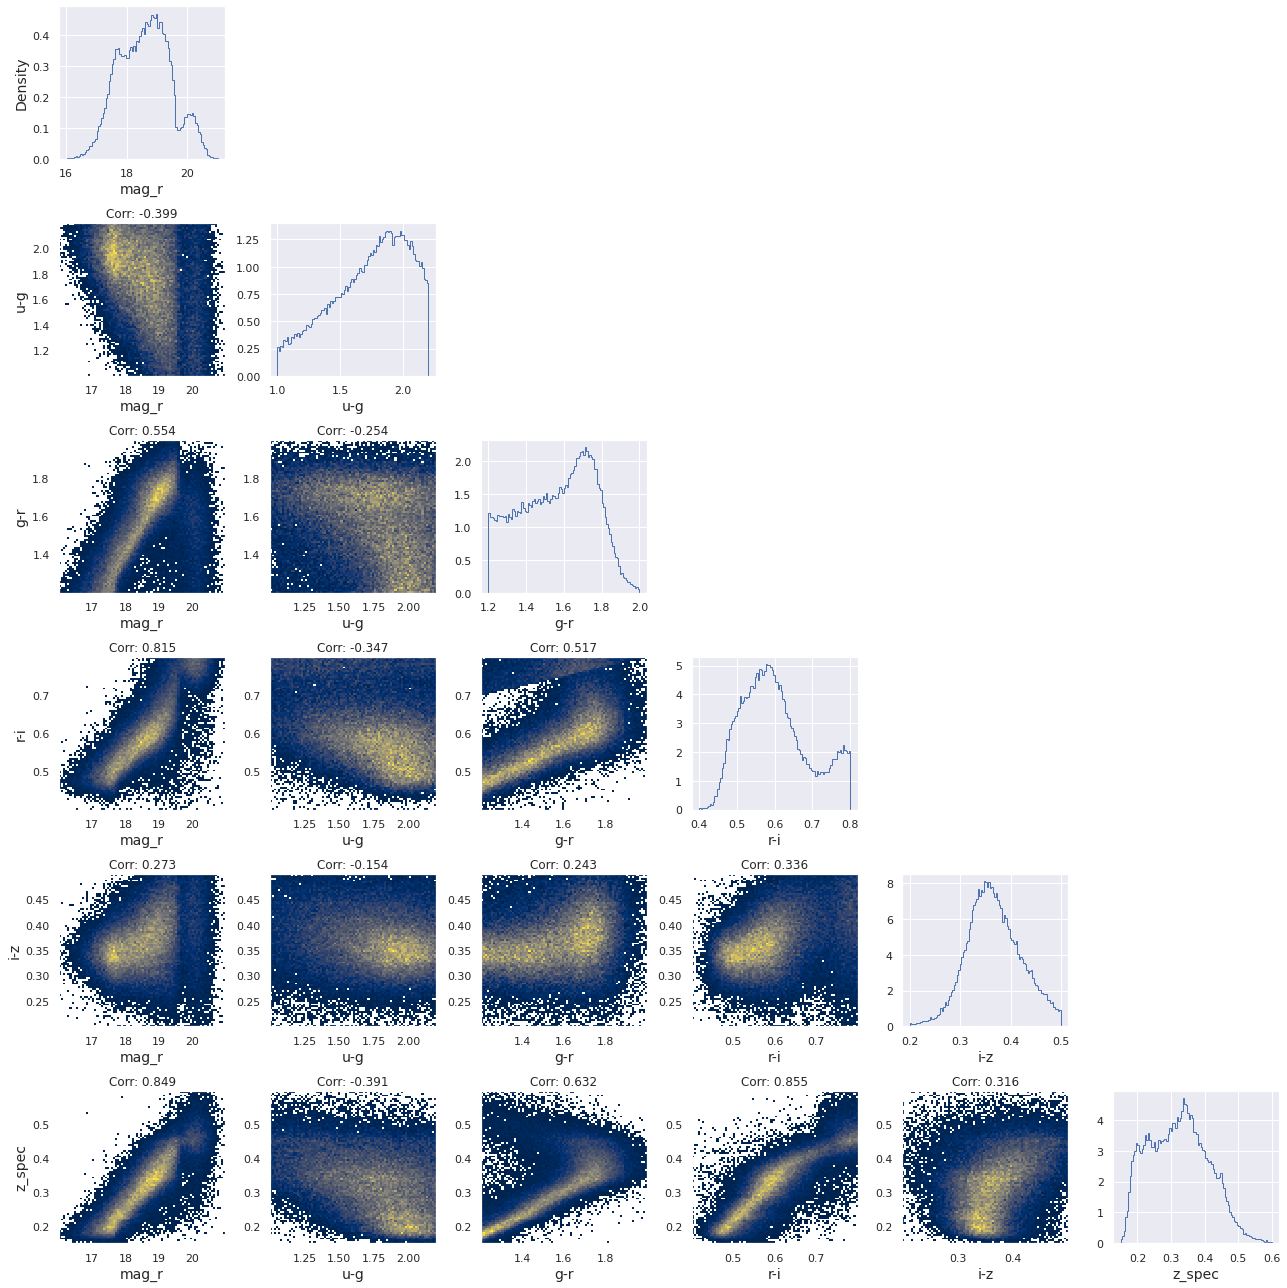

In [8]:
tA = tA_orig.copy()
tB = tB_orig.copy()

remove_outlier_condition = ~(tA['mag_r'] < 16) & ~(tA['r-i'] < 0.4) & \
~(tA['z_spec'] < 0.15) & ~(tA['z_spec'] > 0.6)

tA = tA[remove_outlier_condition]
tA = tA.reset_index(drop=True)

remove_outlier_condition = ~(tB['mag_r'] < 16) & ~(tB['r-i'] < 0.4) & \
~(tB['z_spec'] < 0.15) & ~(tB['z_spec'] > 0.6)

tB = tB[remove_outlier_condition]
tB = tB.reset_index(drop=True)

corr_cornerplot(tA, tA.columns)

### Normalize and standardize the data

In [9]:
## Create normalized and standardized versions of the datasets

tA_norm = tA.copy()
tA_stand = tA.copy()
tB_norm = tB.copy()
tB_stand = tB.copy()

cols = [col for col in tA.columns if col != 'z_spec'] 
for key in cols:
    ## Make normalized
    tA_norm[key] = (tA[key] - np.average(tA[key]))/(np.std(tA[key]))
    tB_norm[key] = (tB[key] - np.average(tB[key]))/(np.std(tB[key]))
    
    ## Make standardized
    tA_stand[key] = (tA[key] - min(tA[key]))/(max(tA[key]) - min(tA[key]))
    tB_stand[key] = (tB[key] - min(tB[key]))/(max(tB[key]) - min(tB[key]))

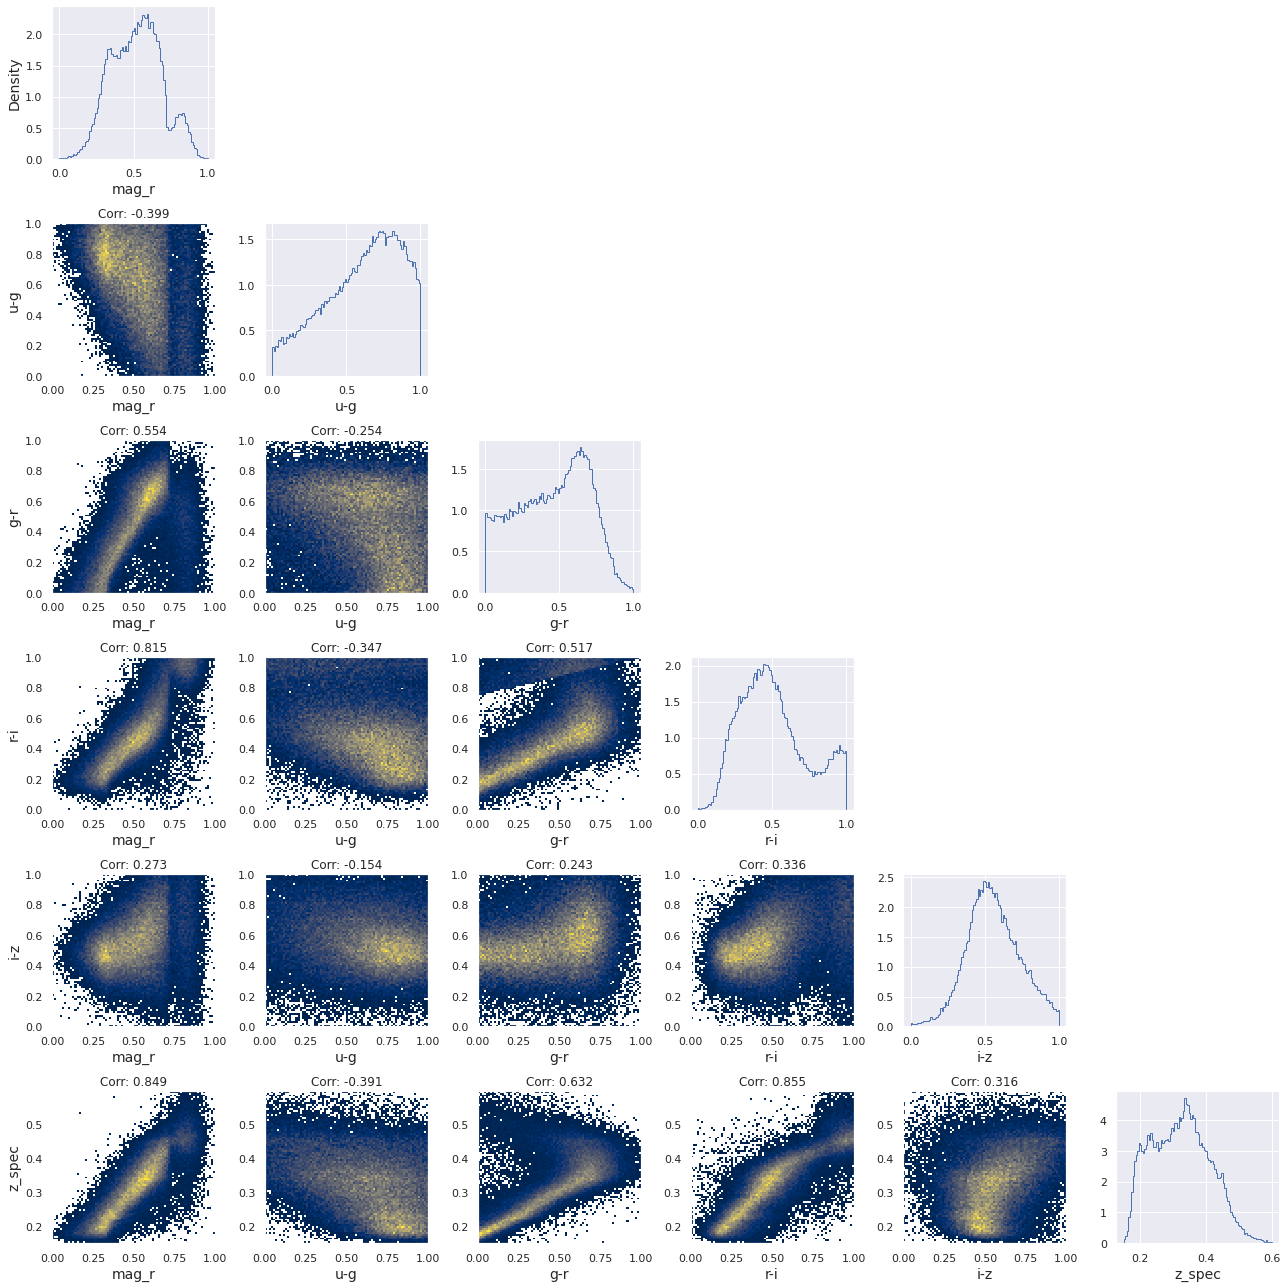

In [10]:
corr_cornerplot(tA_stand, tA_stand.columns)

### Perform Principal Component Analysis

In [11]:
def make_PCA(dfA, dfB):
    cols = [col for col in tA.columns if col != 'z_spec'] 
    X = np.array(dfA[cols])
    y = np.array(dfA['z_spec'])
    
    X_val = np.array(dfB[cols])
    y_val = np.array(dfB['z_spec'])
    
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X)
    X_val_pca = pca.transform(X_val)
    
    
    print("Explained Variance Ratio:", pca.explained_variance_ratio_)
    print("Transformed Dataset:", X_pca)
    print("Transformed Validation Dataset:", X_val_pca)
    
    df_X_pca = pd.DataFrame(X_pca)
    df_X_pca = df_X_pca.rename(columns={0: 'PCA1', 1 : 'PCA2', 2 : 'PCA3', 3 : 'PCA4', 4 :'PCA5'})
    df_X_pca['z_spec'] = dfA['z_spec']

    df_X_val_pca = pd.DataFrame(X_val_pca)
    df_X_val_pca = df_X_val_pca.rename(columns={0: 'PCA1', 1 : 'PCA2', 2 : 'PCA3', 3 : 'PCA4', 4 :'PCA5'})
    df_X_val_pca['z_spec'] = dfB['z_spec']
    
    return df_X_pca, df_X_val_pca

Explained Variance Ratio: [0.87861938 0.08697046 0.02840505 0.00356566 0.00243945]
Transformed Dataset: [[-0.22944696 -0.39203274  0.21630926  0.15498522  0.03510401]
 [-0.80903773  0.05620677  0.11474488  0.05529713  0.11746568]
 [-1.40443203  0.48972825 -0.01705705  0.04565676  0.01770015]
 ...
 [-1.72975696 -0.30180516  0.41663124 -0.05488687  0.01447885]
 [ 0.42726491  0.31762395  0.03094777 -0.00739918 -0.00853514]
 [ 0.99499213  0.35872534 -0.08120285 -0.05471708 -0.01844119]]
Transformed Validation Dataset: [[-8.73167477e-01  5.90934170e-02  2.00630815e-01  1.61989516e-01
   2.06879487e-02]
 [ 1.36155809e+00 -1.94796361e-01  8.54892763e-02  4.19285003e-02
  -3.63382653e-02]
 [-1.09134668e+00 -6.34067502e-01  1.20820101e-02  1.57877583e-01
  -4.83638127e-02]
 ...
 [-1.54215861e-01  4.34362013e-01 -1.45227851e-02  7.26909864e-02
  -1.16045091e-02]
 [ 8.57694952e-01 -1.46440793e-01  8.85074419e-02  2.85348227e-03
   5.17702935e-03]
 [ 6.21343230e-01 -4.02814963e-02 -2.32385858e-02 

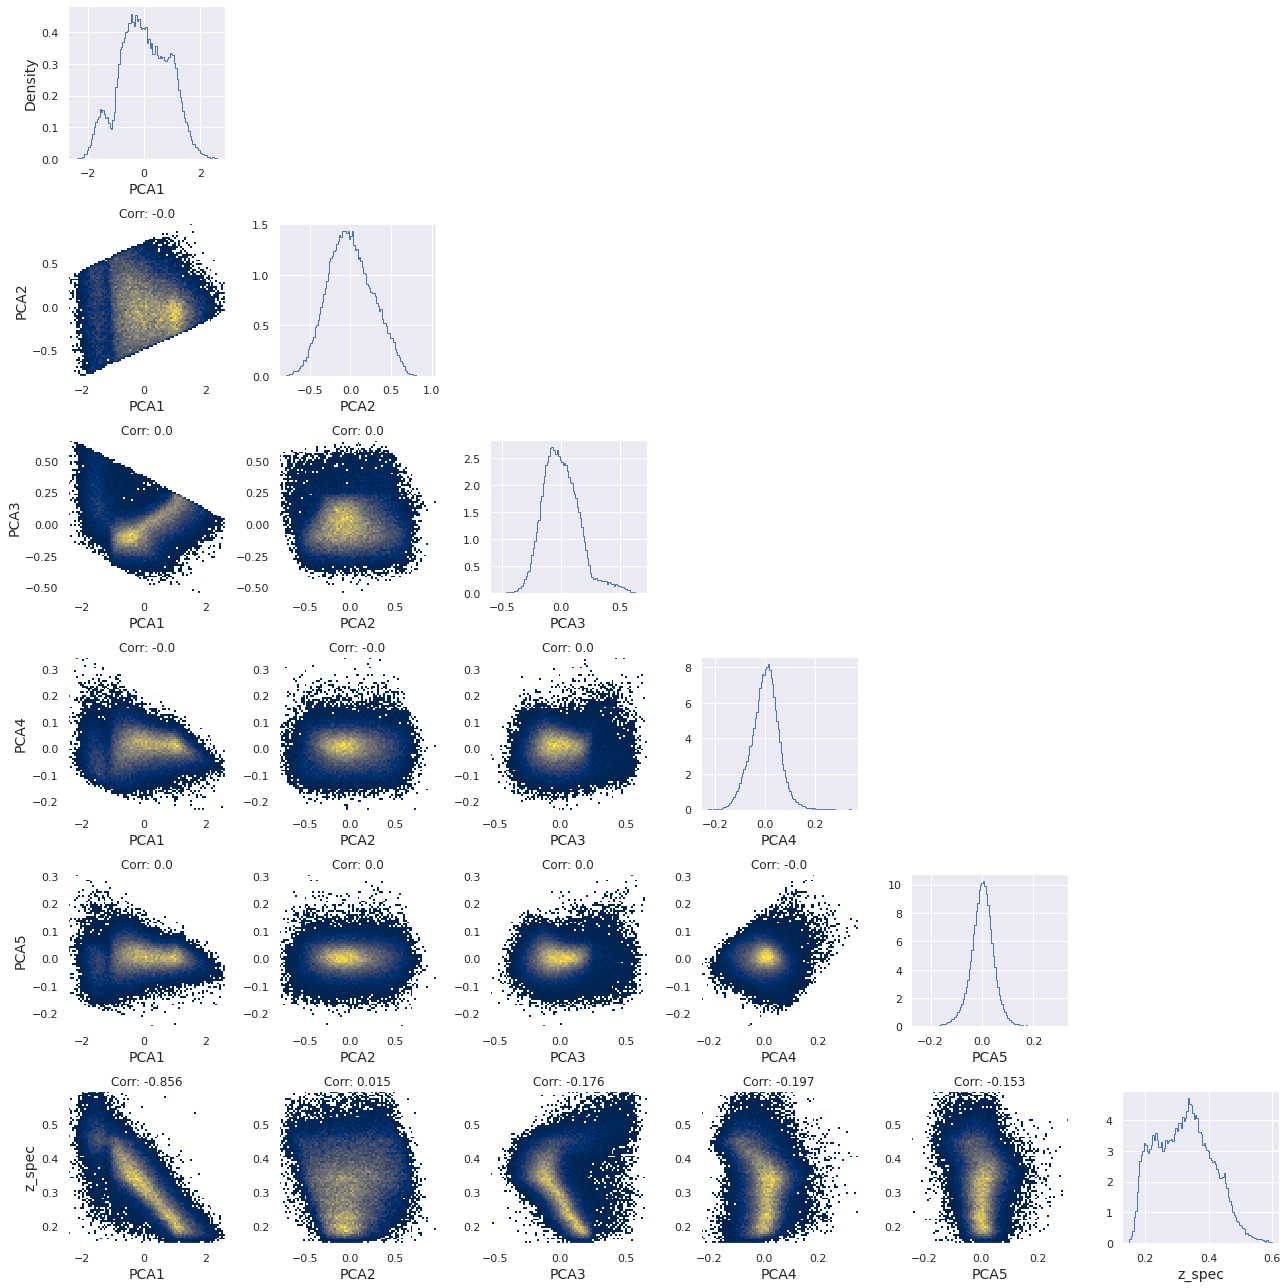

In [12]:
df_X_pca, df_X_val_pca = make_PCA(tA, tB)

corr_cornerplot(df_X_pca, df_X_pca.columns)

### Saving the preprocessed versions of the data

In [14]:
df_X_pca.to_csv('../Datafiles/PhotoZFileA_preprocessed.csv', index=False)
df_X_val_pca.to_csv('../Datafiles/PhotoZFileB_preprocessed.csv', index=False)